### 2.1 Ex. 1

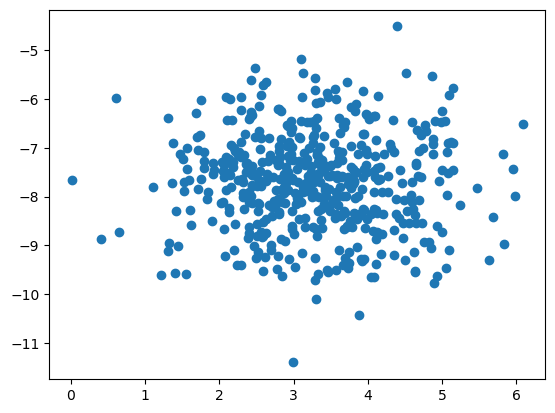

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(n_samples=500, n_features=2, centers=1)
plt.scatter(X[:, 0], X[:, 1])

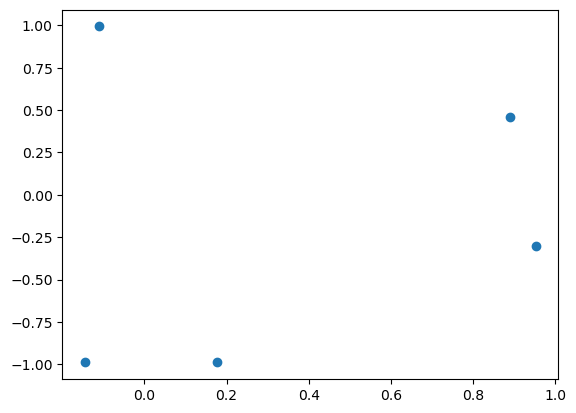

In [58]:
from numpy.random import multivariate_normal

proj_vectors = multivariate_normal(mean=[0, 0], cov=np.eye(2, 2), size=5)
proj_vectors = proj_vectors / np.expand_dims(np.linalg.norm(proj_vectors, axis=1), 1)
plt.scatter(proj_vectors[:, 0], proj_vectors[:, 1])

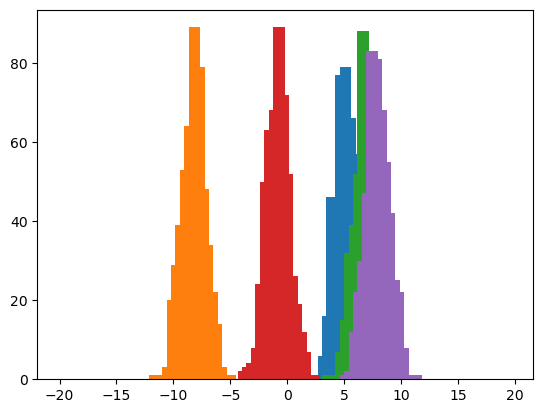

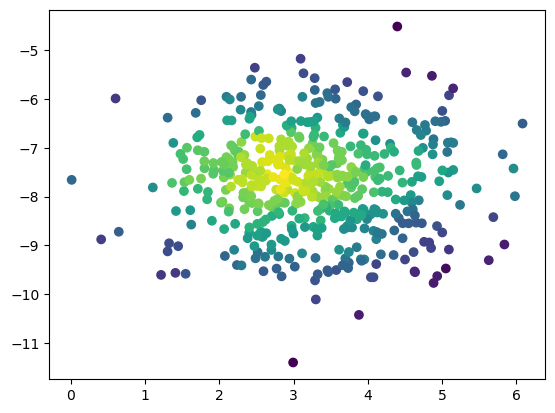

In [ ]:
# X_proj = np.expand_dims(X[:, 0], 1) * np.expand_dims(proj_vectors[:, 0], 0) + np.expand_dims(X[:, 1], 1) * np.expand_dims(proj_vectors[:, 1], 0)
X_proj = X @ proj_vectors.T
low = X_proj.min()
high = X_proj.max()
dist = high - low
low -= dist / 3
high += dist / 3
scores = []
for idx in range(5):
    projections = X_proj[:, idx]    
    hist, bin_edges = np.histogram(projections, bins=100, range=(low, high))
    probs = hist / np.sum(hist)
    indices = np.digitize(projections, bin_edges)
    scores.append(probs[indices])
    plt.bar(bin_edges[:-1], hist, width=1)
scores = np.vstack(scores).mean(axis=0)

threshold = np.quantile(scores, q=0.1)
is_outlier = scores < threshold
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=scores)

In [168]:
class LodaModel:
    def __init__(self, n_proj_vectors: int = 5, contamination: float = 0.1, n_bins: int = 100) -> None:
        self.n_proj_vectors = n_proj_vectors
        self.proj_vectors = multivariate_normal(mean=[0, 0], cov=np.eye(2, 2), size=n_proj_vectors)
        self.proj_vectors = self.proj_vectors / np.expand_dims(np.linalg.norm(self.proj_vectors, axis=1), 1)
        self.hists: list[np.ndarray] = []
        self.bin_edges: list[np.ndarray] = []
        self.probs: list[np.ndarray] = []
        self.contamination = contamination
        self.n_bins = n_bins

    def fit(self, X_train: np.ndarray) -> None:
        X_proj = X_train @ self.proj_vectors.T
        low = X_proj.min()
        high = X_proj.max()
        dist = high - low
        low -= dist / 3
        high += dist / 3
        for idx in range(self.n_proj_vectors):
            projections = X_proj[:, idx]    
            hist, bin_edges = np.histogram(projections, bins=self.n_bins, range=(low, high))
            self.probs.append(hist / np.sum(hist))
            self.hists.append(hist)
            self.bin_edges.append(bin_edges)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        X_proj = X_test @ self.proj_vectors.T
        scores = []
        for idx in range(self.n_proj_vectors):
            projections = X_proj[:, idx]
            probs = self.probs[idx]
            bin_edges = self.bin_edges[idx]
            indices = np.digitize(projections, bin_edges)
            scores.append(probs[indices])
        scores = np.vstack(scores).mean(axis=0)

        return scores

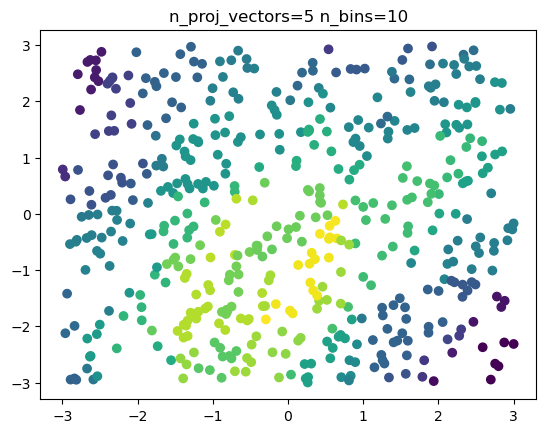

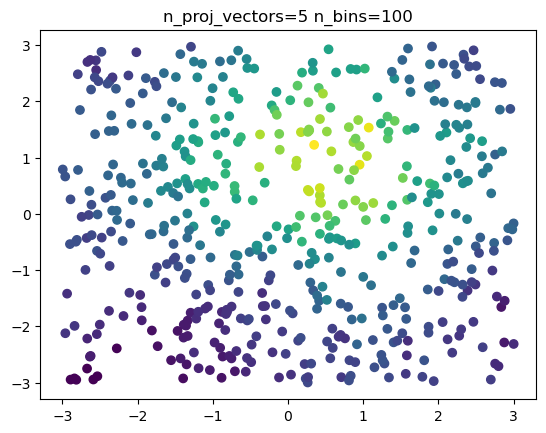

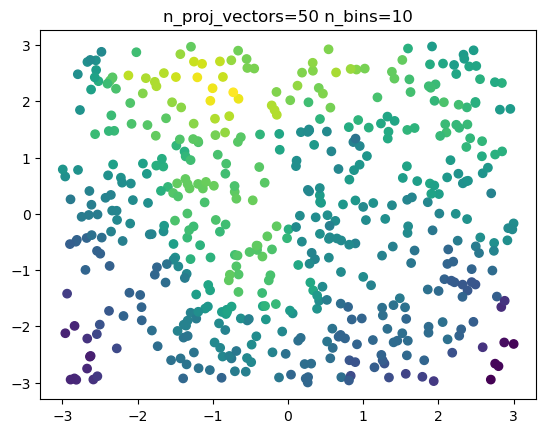

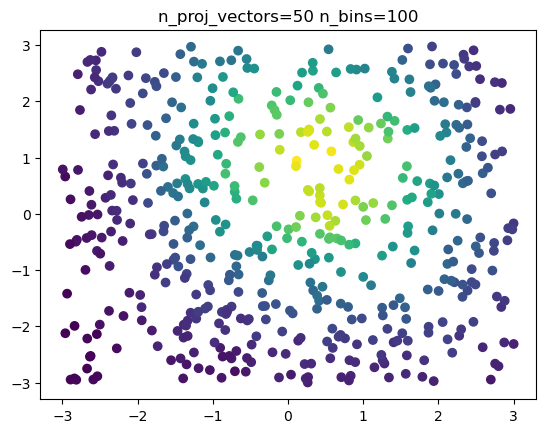

In [180]:
X_train, y_train = make_blobs(n_samples=500, n_features=2, centers=1, center_box=(-1, 1))
X_test = np.random.uniform(low=-3, high=3, size=(500, 2))

for n_proj_vectors, n_bins in zip([5, 5, 50, 50], [10, 100, 10, 100]):
    model = LodaModel(n_proj_vectors=n_proj_vectors, contamination=0.1, n_bins=n_bins)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure()
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
    plt.title(f"n_proj_vectors={n_proj_vectors} n_bins={n_bins}")
    plt.savefig(f"plots/Ex 2.1 n_proj_vectors={n_proj_vectors} n_bins={n_bins}.jpg")

### 2.2 Ex. 2

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.base import BaseDetector
from pyod.models.dif import DIF
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from sklearn.datasets import make_blobs

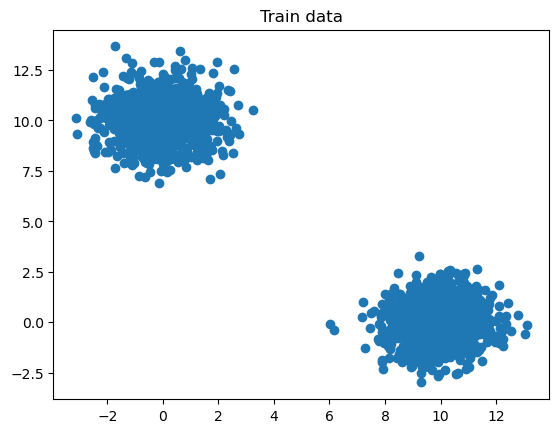

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


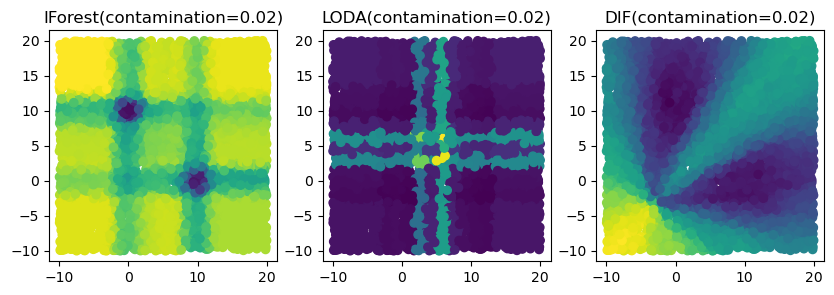

In [41]:
def fit_model(model: BaseDetector, name: str) -> None:
    model.fit(X_train, y_train)
    scores = model.decision_function(X_test)
    # Plot test data
    plt.scatter(*X_test.T, c=scores)
    plt.title(name)


# Generate data
X_train, y_train = make_blobs(n_samples=2000, n_features=2, centers=[[10, 0], [0, 10]], cluster_std=1)
X_test = np.random.uniform(low=-10, high=20, size=(5000, 2))
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.title("Train data")
plt.show()

plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
fit_model(model=IForest(contamination=0.02), name="IForest(contamination=0.02)")
plt.subplot(1, 3, 2)
fit_model(model=LODA(contamination=0.02), name="LODA(contamination=0.02)")
plt.subplot(1, 3, 3)
fit_model(model=DIF(contamination=0.02), name="DIF(contamination=0.02)")
plt.savefig("plots/Ex 2.2.4.jpg")
plt.show()

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


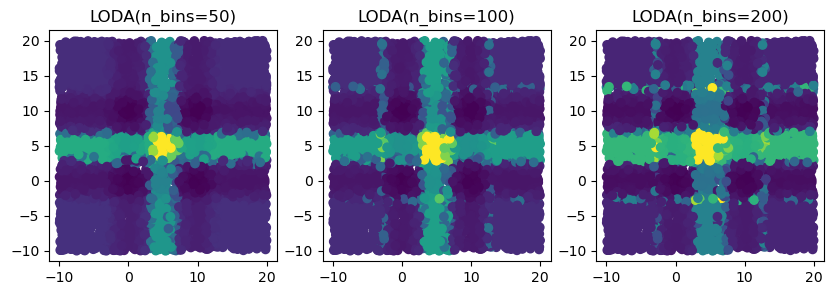

In [42]:
plt.figure(figsize=(10, 3))
for idx, n_bins in enumerate([50, 100, 200]):
    plt.subplot(1, 3, idx + 1)
    fit_model(model=LODA(contamination=0.02, n_bins=n_bins), name=f"LODA(n_bins={n_bins})")
plt.savefig("plots/Ex 2.2.5 n_bins=50,100,200.jpg")
plt.show()

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


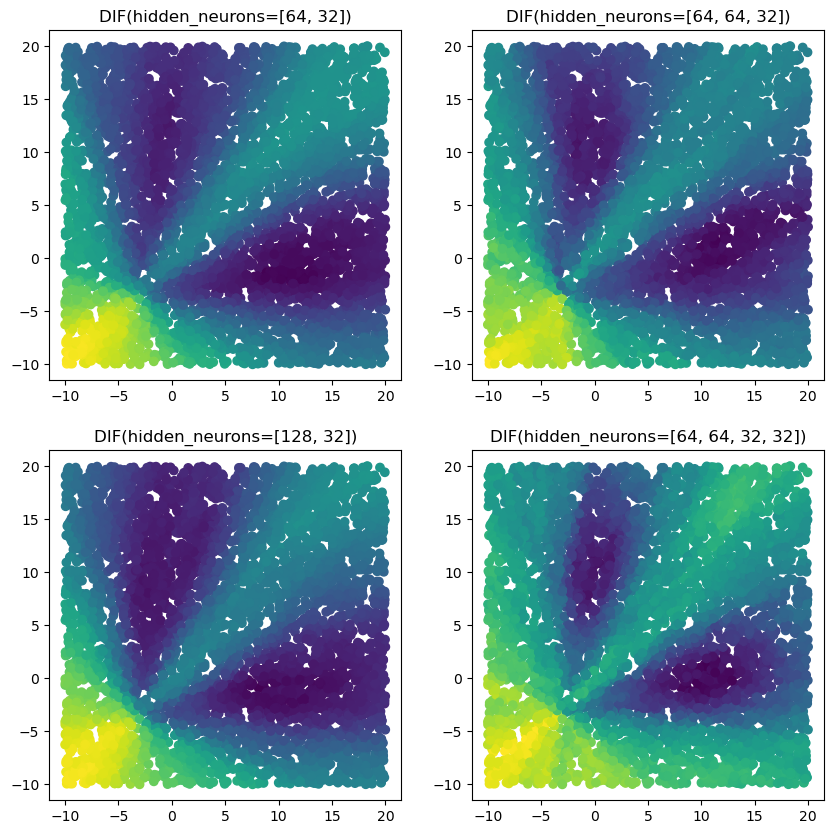

In [24]:
plt.figure(figsize=(10, 10))
for idx, hidden_neurons in enumerate([[64, 32], [64, 64, 32], [128, 32], [64, 64, 32, 32]]):
    plt.subplot(2, 2, idx + 1)
    fit_model(
        model=DIF(contamination=0.02, hidden_neurons=hidden_neurons), name=f"DIF(hidden_neurons={hidden_neurons})"
    )
plt.savefig("plots/Ex 2.2.5 DIF.jpg")
plt.show()

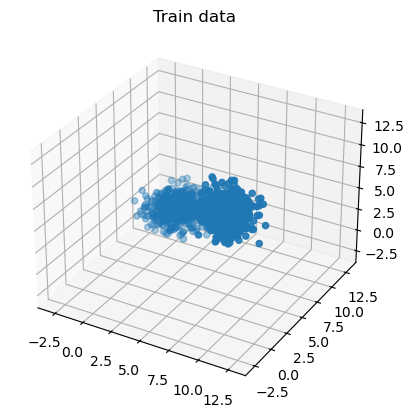

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np

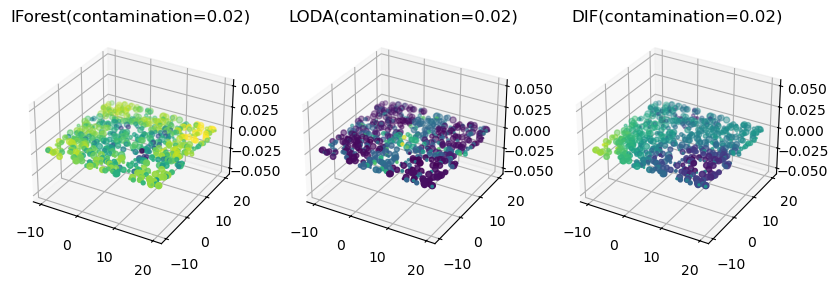

In [43]:
# Generate data
X_train, y_train = make_blobs(n_samples=1000, n_features=3, centers=[[0, 10, 0], [10, 0, 10]], cluster_std=1)
X_test = np.random.uniform(low=-10, high=20, size=(1000, 3))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.scatter(*X_train.T)
ax.set_title("Train data")
plt.show()

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 3, 1, projection="3d")
fit_model(model=IForest(contamination=0.02), name="IForest(contamination=0.02)")
ax = fig.add_subplot(1, 3, 2, projection="3d")
fit_model(model=LODA(contamination=0.02), name="LODA(contamination=0.02)")
ax = fig.add_subplot(1, 3, 3, projection="3d")
fit_model(model=DIF(contamination=0.02), name="DIF(contamination=0.02)")
plt.savefig("plots/Ex 2.2.6.3.jpg")
plt.show()

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np

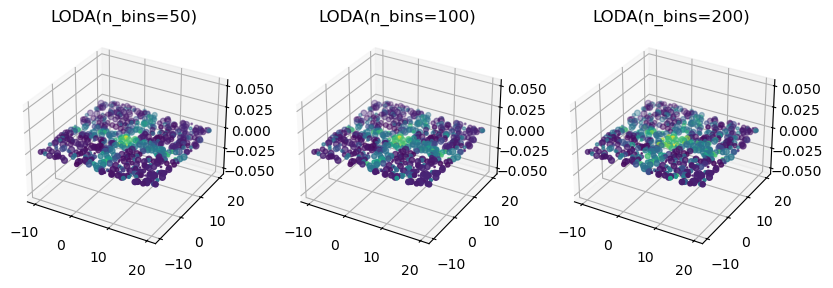

In [40]:
fig = plt.figure(figsize=(10, 3))
for idx, n_bins in enumerate([50, 100, 200]):
    fig.add_subplot(1, 3, idx + 1, projection="3d")
    fit_model(model=LODA(contamination=0.02, n_bins=n_bins), name=f"LODA(n_bins={n_bins})")
plt.savefig("plots/Ex 2.2.6.4 n_bins=50,100,200.jpg")
plt.show()

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np

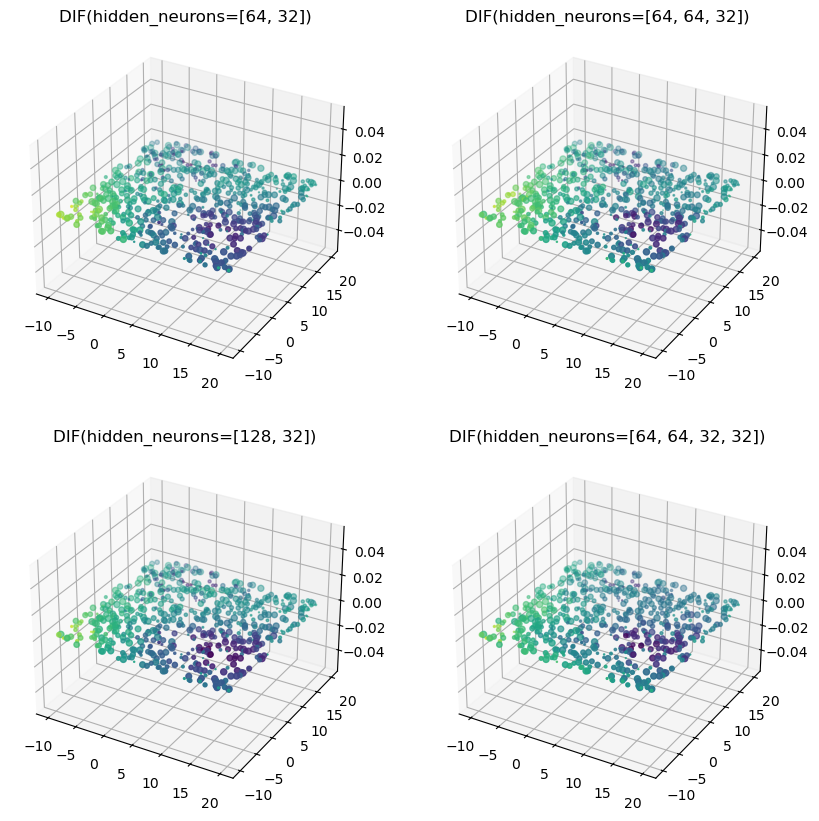

In [45]:
fig = plt.figure(figsize=(10, 10))
for idx, hidden_neurons in enumerate([[64, 32], [64, 64, 32], [128, 32], [64, 64, 32, 32]]):
    fig.add_subplot(2, 2, idx + 1, projection="3d")
    fit_model(
        model=DIF(contamination=0.02, hidden_neurons=hidden_neurons), name=f"DIF(hidden_neurons={hidden_neurons})"
    )
plt.savefig("plots/Ex 2.2.6.5 DIF.jpg")
plt.show()

### 2.3 Ex. 3

In [58]:
import numpy as np
from pyod.models.base import BaseDetector
from pyod.models.dif import DIF
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
import re
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

In [75]:
data = loadmat("shuttle.mat")
X: np.ndarray = data["X"]
y: np.ndarray = data["y"]
mean_X = X.mean(axis=0)
std_X = X.std(axis=0)
X = (X - mean_X) / std_X
contamination = np.sum(y) / len(y)
print(f"contamination={contamination}")
models: list[BaseDetector] = [IForest(contamination=contamination), LODA(contamination=contamination), DIF(contamination=contamination)]
model_names: list[str] = ["IForest", "LODA", "DIF"]

contamination=0.0715114976475141


In [76]:
balanced_accs: dict[str, list[float]] = {}
roc_aucs: dict[str, list[float]] = {}
for model_name in model_names:
    balanced_accs[model_name] = []
    roc_aucs[model_name] = []

for random_state in [3, 17, 26, 35, 42, 57, 62, 71, 86, 93]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    for model, model_name in zip(models, model_names):
        model = models[0]
        model.fit(X_train)
        preds = model.predict(X_test)
        scores = model.decision_function(X_test)
        tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=preds).ravel()
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        balanced_acc = (tpr + tnr) / 2
        balanced_accs[model_name].append(balanced_acc)
        roc_auc = roc_auc_score(y_true=y_test, y_score=scores)
        roc_aucs[model_name].append(roc_auc)
        print(
            f"random_state={random_state:<2d} model_name={model_name:<7} balanced_acc={balanced_acc:.6f} roc_auc={roc_auc:.6f}"
        )

random_state=3  model_name=IForest balanced_acc=0.977980 roc_auc=0.997032
random_state=3  model_name=LODA    balanced_acc=0.966226 roc_auc=0.996565
random_state=3  model_name=DIF     balanced_acc=0.976488 roc_auc=0.996548
random_state=17 model_name=IForest balanced_acc=0.980448 roc_auc=0.997001
random_state=17 model_name=LODA    balanced_acc=0.978674 roc_auc=0.997580
random_state=17 model_name=DIF     balanced_acc=0.971411 roc_auc=0.996303
random_state=26 model_name=IForest balanced_acc=0.968133 roc_auc=0.995858
random_state=26 model_name=LODA    balanced_acc=0.978991 roc_auc=0.997441
random_state=26 model_name=DIF     balanced_acc=0.974126 roc_auc=0.996456
random_state=35 model_name=IForest balanced_acc=0.968140 roc_auc=0.996237
random_state=35 model_name=LODA    balanced_acc=0.969038 roc_auc=0.997190
random_state=35 model_name=DIF     balanced_acc=0.982339 roc_auc=0.997787
random_state=42 model_name=IForest balanced_acc=0.958497 roc_auc=0.997177
random_state=42 model_name=LODA    bal

In [77]:
print("### Final Results ###")
for model_name in model_names:
    avg_balanced_acc = np.mean(balanced_accs[model_name])
    avg_roc_auc = np.mean(roc_aucs[model_name])
    print(f"model_name={model_name:7} avg_balanced_acc={avg_balanced_acc:.6f} avg_roc_auc={avg_roc_auc:.6f}")

### Final Results ###
model_name=IForest avg_balanced_acc=0.969051 avg_roc_auc=0.996286
model_name=LODA    avg_balanced_acc=0.969176 avg_roc_auc=0.997080
model_name=DIF     avg_balanced_acc=0.974670 avg_roc_auc=0.996889
